# Machine Learning Modeling


In this notebook, we build an extra tree classifier to predict the likelihood of flight cancellations given flight information, weather data and some historical performances of airlines.

## Loading modules

In [5]:
import pandas as pd
import numpy as np
% pylab inline
import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Setting some plot colors and parameters

In [6]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

## Setting data frame display

In [7]:
pd.set_option('display.max_columns', None)

## Loading the data

We have acquired and merged the data in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataAcquisitionMerging/data_acquisition_merging.ipynb). The merged data was also cleaned by fixing the missing values in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/DataCleaning/data_cleaning.ipynb). A lot of features from the cleaned data was removed (or some features were selected) in [this notebook](https://github.com/aajains/springboard-datascience-intensive/blob/master/capstone_project/EDA/ExploratoryDataAnalysis_v1.ipynb). The resultant csv file is loaded below:

In [4]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [5]:
df.shape

(2857139, 69)

In [6]:
df.head()

,Unnamed: 0,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [7]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [8]:
df.head()

,Month,DayofMonth,DayOfWeek,Carrier,Origin,Dest,Cancelled,Distance,Nflights_10,DepDelayMedian_10,DepDelayMax_10,ArrDelayMedian_10,ArrDelayMax_10,TaxiOutMedian_10,TaxiInMedian_10,Ncan_10,Ndiv_10,Nflights_20,DepDelayMedian_20,DepDelayMax_20,ArrDelayMedian_20,ArrDelayMax_20,TaxiOutMedian_20,TaxiInMedian_20,Ncan_20,Ndiv_20,Nflights_30,DepDelayMedian_30,DepDelayMax_30,ArrDelayMedian_30,ArrDelayMax_30,TaxiOutMedian_30,TaxiInMedian_30,Ncan_30,Ndiv_30,CRSDepHr,CRSArrHr,Temperature_Origin,DewPoint_Origin,Humidity_Origin,WindSpeed_Origin,WindDirection_Origin,Visibility_Origin,Pressure_Origin,Condition_Origin,Temperature_Dest,DewPoint_Dest,Humidity_Dest,WindSpeed_Dest,WindDirection_Dest,Visibility_Dest,Pressure_Dest,Condition_Dest,Month_Dest,DayOfMonth_Dest,DayOfWeek_Dest,TempFlight_30,TempFlight_20,TempFlight_10,AllCanceled_30,AllDiverted_30,AllCanceled_20,AllDiverted_20,AllCanDiv_20,AllCanDiv_30,AllCanceled_10,AllDiverted_10,AllCanDiv_10
0,1,1,4,AA,PHX,DFW,1.0,868.0,10,-2.0,0.0,-2.5,17.0,13.0,4.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,14,-2.0,0.0,-0.5,17.0,13.0,5.0,0.0,0.0,2,5,37.0,30.0,76.0,3.5,320.0,10.0,30.04,Scattered Clouds,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,4,NK,PHX,DFW,0.0,868.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,37.0,30.9,79.0,4.6,300.0,10.0,30.03,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
2,1,1,4,DL,DEN,ATL,0.0,1199.0,10,3.5,48.0,-7.5,52.0,15.0,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,12,3.5,48.0,-7.5,52.0,14.5,6.5,0.0,0.0,0,5,7.0,-8.0,51.0,15.0,170.0,10.0,30.22,Clear,33.1,26.1,75.0,3.5,310.0,10.0,30.32,Partly Cloudy,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,4,NK,LAS,MSP,0.0,1299.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5,34.0,17.1,50.0,9.2,190.0,10.0,29.99,Mostly Cloudy,16.0,10.0,77.0,8.1,240.0,10.0,29.90,Overcast,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0
4,1,1,4,NK,LAS,DFW,0.0,1055.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,32.0,17.1,54.0,10.4,190.0,10.0,30.00,Mostly Cloudy,33.1,27.0,78.0,8.1,350.0,10.0,30.34,Light Rain,1,1,4,1,1,1,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(2857139, 68)

There are some variables with numerical values and some variables with categories. For numerical variables, we do not have to worry about labelling. However, we will need to perform label encoding for the categorical variables. There are also some variables that are already in binary form, so that also does not need any labeling. Let's first identify all the numerical, categorical and binary variables.

In [10]:
numvar = ["Distance", "Nflights_10", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "ArrDelayMax_10", "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "Nflights_20",
          "DepDelayMedian_20", "DepDelayMax_20", "ArrDelayMedian_20", "ArrDelayMax_20", "TaxiOutMedian_20",
          "TaxiInMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", "DepDelayMax_30", 
          "ArrDelayMedian_30", "ArrDelayMax_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest"]
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
binvar = ["TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllDiverted_30", 
          "AllCanceled_20", "AllDiverted_20", "AllCanDiv_20", "AllCanDiv_30", "AllCanceled_10", 
          "AllDiverted_10", "AllCanDiv_10"]

## Converting string values to numerical values in all categorical columns

In [11]:
#from sklearn.preprocessing import LabelEncoder
#lbl_enc = LabelEncoder()
#tmp = df[catvar].apply(lbl_enc.fit_transform) 
#df.drop(catvar, axis=1, inplace=True)
#df = pd.concat([df, tmp], axis=1)

In [12]:
#One-hot-encoding
for cvar in catvar:
    df = pd.concat([df, pd.get_dummies(df[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df.drop([cvar], axis=1, inplace=True)

In [13]:
df.shape

(2857139, 331)

In [14]:
colnames = list(df.columns[1:])

## Creating feature matrix and target vector

In [15]:
X = df.drop(["Cancelled"], axis=1).values
y = df.Cancelled.astype(int).values

In [16]:
X.shape

(2857139, 330)

## Splitting the data into train (75%) and test (25%) sets

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=20)
for train_index, test_index in sss1.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [18]:
X_train.shape

(2142854, 330)

In [19]:
X_test.shape

(714285, 330)

Just to make sure that stratified shuffle split led to train and test with same fraction of positive class, lets calculate the fractions.

In [20]:
sum(df.iloc[train_index].Cancelled == 1)/len(train_index)

0.011486550180273598

In [21]:
sum(df.iloc[test_index].Cancelled == 1)/len(test_index)

0.011487011487011487

They are indeed quite similar.

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as pl
from imblearn.under_sampling import RandomUnderSampler

In [46]:
%%time
# Steps for pipeline
steps = [("model", ExtraTreesClassifier(random_state=40))]
pipe = pl(steps)
kf = 5
# Parameters
param_grid = dict(model__n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200],
                  model__max_features = ['sqrt'],
                  model__min_samples_leaf = [4],
                 model__class_weight = ['balanced'])
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = kf, test_size = 1/kf, random_state = 20)

# Setting up the grid search
ETcw = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 1,
                           cv = cv,
                          n_jobs=-1,
                          scoring='average_precision',
                          iid=False)
# Training using CV
ETcw.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 66.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 191.3min finished


CPU times: user 28min 25s, sys: 37.8 s, total: 29min 2s
Wall time: 3h 38min 6s


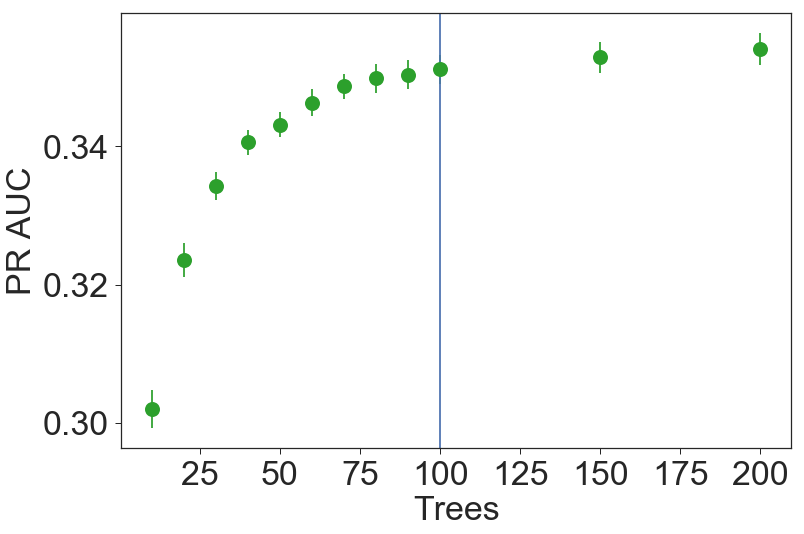

In [47]:
df_et = pd.DataFrame(OrderedDict({"Trees": ETcw.cv_results_['param_model__n_estimators'].data,
                     "PR AUC": ETcw.cv_results_['mean_test_score'], 
                                  "PR AUC Er": ETcw.cv_results_['std_test_score']/sqrt(kf), 
                                  "CPU Time": ETcw.cv_results_['mean_fit_time'], 
                                  "CPU Time Er": ETcw.cv_results_['std_fit_time']/sqrt(kf)}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.errorbar(df_et.Trees, df_et["PR AUC"], df_et["PR AUC Er"], color=tableau20[4], fmt='o', markersize = 15)
ax1.set_ylabel("PR AUC", size=34)
plt.xticks(fontsize=34)
plt.xlabel("Trees", size=34)
ax1.tick_params('y', labelsize=34)

plt.axvline(100)
# training data: 0.75
# OHE - no
# kf = 5

In [23]:
%%time
# Steps for pipeline
steps = [("model", ExtraTreesClassifier(random_state=40))]
pipe = pl(steps)
kf = 3
# Parameters
param_grid = dict(model__n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200],
                  model__max_features = ['sqrt'],
                  model__min_samples_leaf = [4],
                 model__class_weight = ['balanced'])
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = kf, test_size = 1/kf, random_state = 20)

# Setting up the grid search
ETcw = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 1,
                           cv = cv,
                          n_jobs=-1,
                          scoring='average_precision',
                          iid=False)
# Training using CV
ETcw.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 77.0min finished


CPU times: user 18min 24s, sys: 31.4 s, total: 18min 55s
Wall time: 1h 33min 43s


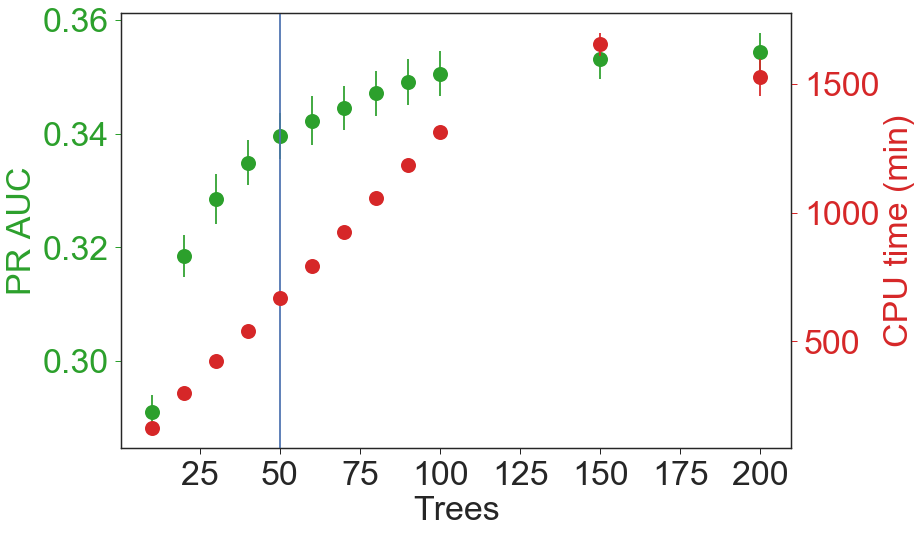

In [24]:
df_et = pd.DataFrame(OrderedDict({"Trees": ETcw.cv_results_['param_model__n_estimators'].data,
                     "PR AUC": ETcw.cv_results_['mean_test_score'], 
                                  "PR AUC Er": ETcw.cv_results_['std_test_score']/sqrt(kf), 
                                  "CPU Time": ETcw.cv_results_['mean_fit_time'], 
                                  "CPU Time Er": ETcw.cv_results_['std_fit_time']/sqrt(kf)}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.errorbar(df_et.Trees, df_et["PR AUC"], df_et["PR AUC Er"], color=tableau20[4], fmt='o', markersize = 15)
ax1.set_ylabel("PR AUC", size=34, color=tableau20[4])
plt.xticks(fontsize=34)
plt.xlabel("Trees", size=34)
ax1.tick_params('y', colors=tableau20[4], labelsize=34)

ax2 = ax1.twinx()
ax2.errorbar(df_et.Trees, df_et["CPU Time"], df_et["CPU Time Er"], color=tableau20[6], fmt='o', markersize=15)
ax2.set_ylabel("CPU time (min)", size=34, color=tableau20[6])
ax2.tick_params('y', colors=tableau20[6], labelsize = 34)

plt.axvline(50)

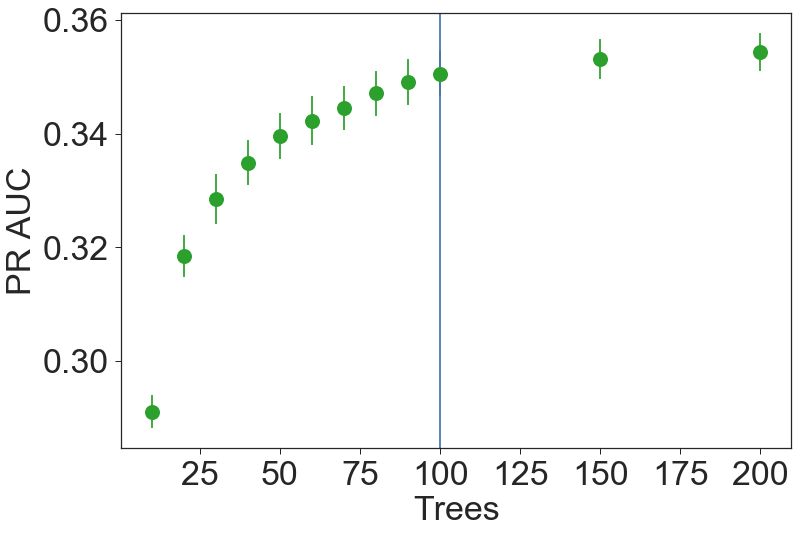

In [26]:
df_et = pd.DataFrame(OrderedDict({"Trees": ETcw.cv_results_['param_model__n_estimators'].data,
                     "PR AUC": ETcw.cv_results_['mean_test_score'], 
                                  "PR AUC Er": ETcw.cv_results_['std_test_score']/sqrt(kf), 
                                  "CPU Time": ETcw.cv_results_['mean_fit_time'], 
                                  "CPU Time Er": ETcw.cv_results_['std_fit_time']/sqrt(kf)}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.errorbar(df_et.Trees, df_et["PR AUC"], df_et["PR AUC Er"], color=tableau20[4], fmt='o', markersize = 15)
ax1.set_ylabel("PR AUC", size=34)
plt.xticks(fontsize=34)
plt.xlabel("Trees", size=34)
ax1.tick_params('y', labelsize=34)

plt.axvline(100)
# training data: 0.25
# OHE - yes
# kf = 3

In [35]:
ETcw.cv_results_

{'mean_fit_time': array([ 12.65831099,  25.12670817,  36.69439378,  48.01690617,  44.35996008]),
 'mean_score_time': array([ 0.22593455,  0.39938035,  0.57300191,  0.75380907,  0.52162967]),
 'mean_test_score': array([ 0.21536324,  0.2458235 ,  0.25870399,  0.26581241,  0.27106402]),
 'mean_train_score': array([ 0.99888291,  0.99973126,  0.99988126,  0.99989631,  0.99991648]),
 'param_model__class_weight': masked_array(data = ['balanced' 'balanced' 'balanced' 'balanced' 'balanced'],
              mask = [False False False False False],
        fill_value = ?),
 'param_model__max_features': masked_array(data = ['sqrt' 'sqrt' 'sqrt' 'sqrt' 'sqrt'],
              mask = [False False False False False],
        fill_value = ?),
 'param_model__min_samples_leaf': masked_array(data = [4 4 4 4 4],
              mask = [False False False False False],
        fill_value = ?),
 'param_model__n_estimators': masked_array(data = [10 20 30 40 50],
              mask = [False False False False False]

In [23]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
ETcw1 = ExtraTreesClassifier(random_state=40, n_estimators = 100, min_samples_leaf=4, class_weight="balanced", n_jobs = -1)
ETcw1.fit(X_train, y_train)

CPU times: user 1h 42min 5s, sys: 26.1 s, total: 1h 42min 31s
Wall time: 14min 5s


In [25]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
average_precision_score(y_test, ETcw1.predict_proba(X_test)[:,1])

0.40371576850900165

1 Carrier_DL 0.0270701720563
2 Humidity_Origin 0.0182962012294
3 Humidity_Dest 0.0171890465452
4 Ncan_30 0.0168264019641
5 Ncan_10 0.0164319928066
6 Temperature_Origin 0.0159474313544
7 Temperature_Dest 0.0152726855754
8 Visibility_Origin 0.0146438467894
9 Ncan_20 0.0146420977292
10 Visibility_Dest 0.013320710489
11 Distance 0.012214577683
12 DewPoint_Dest 0.0108656278396
13 DewPoint_Origin 0.0107422305836
14 Condition_Origin_Light Snow 0.00937788157486
15 Condition_Dest_Light Snow 0.0093477041954
16 Month_Dest_2 0.00921900322708
17 WindDirection_Origin 0.00840521674031
18 Month_Dest_1 0.00828082674289
19 WindDirection_Dest 0.00812416250219
20 Month_1 0.00796638856162
21 Pressure_Origin 0.00772486295815
22 WindSpeed_Origin 0.00745706076393
23 Month_2 0.00740622000304
24 WindSpeed_Dest 0.00706828386933
25 Pressure_Dest 0.00700526707696
26 Carrier_AA 0.0070046902663
27 Condition_Origin_Mostly Cloudy 0.00684118534737
28 Condition_Dest_Mostly Cloudy 0.00670826353098
29 Month_Dest_9 0.00659

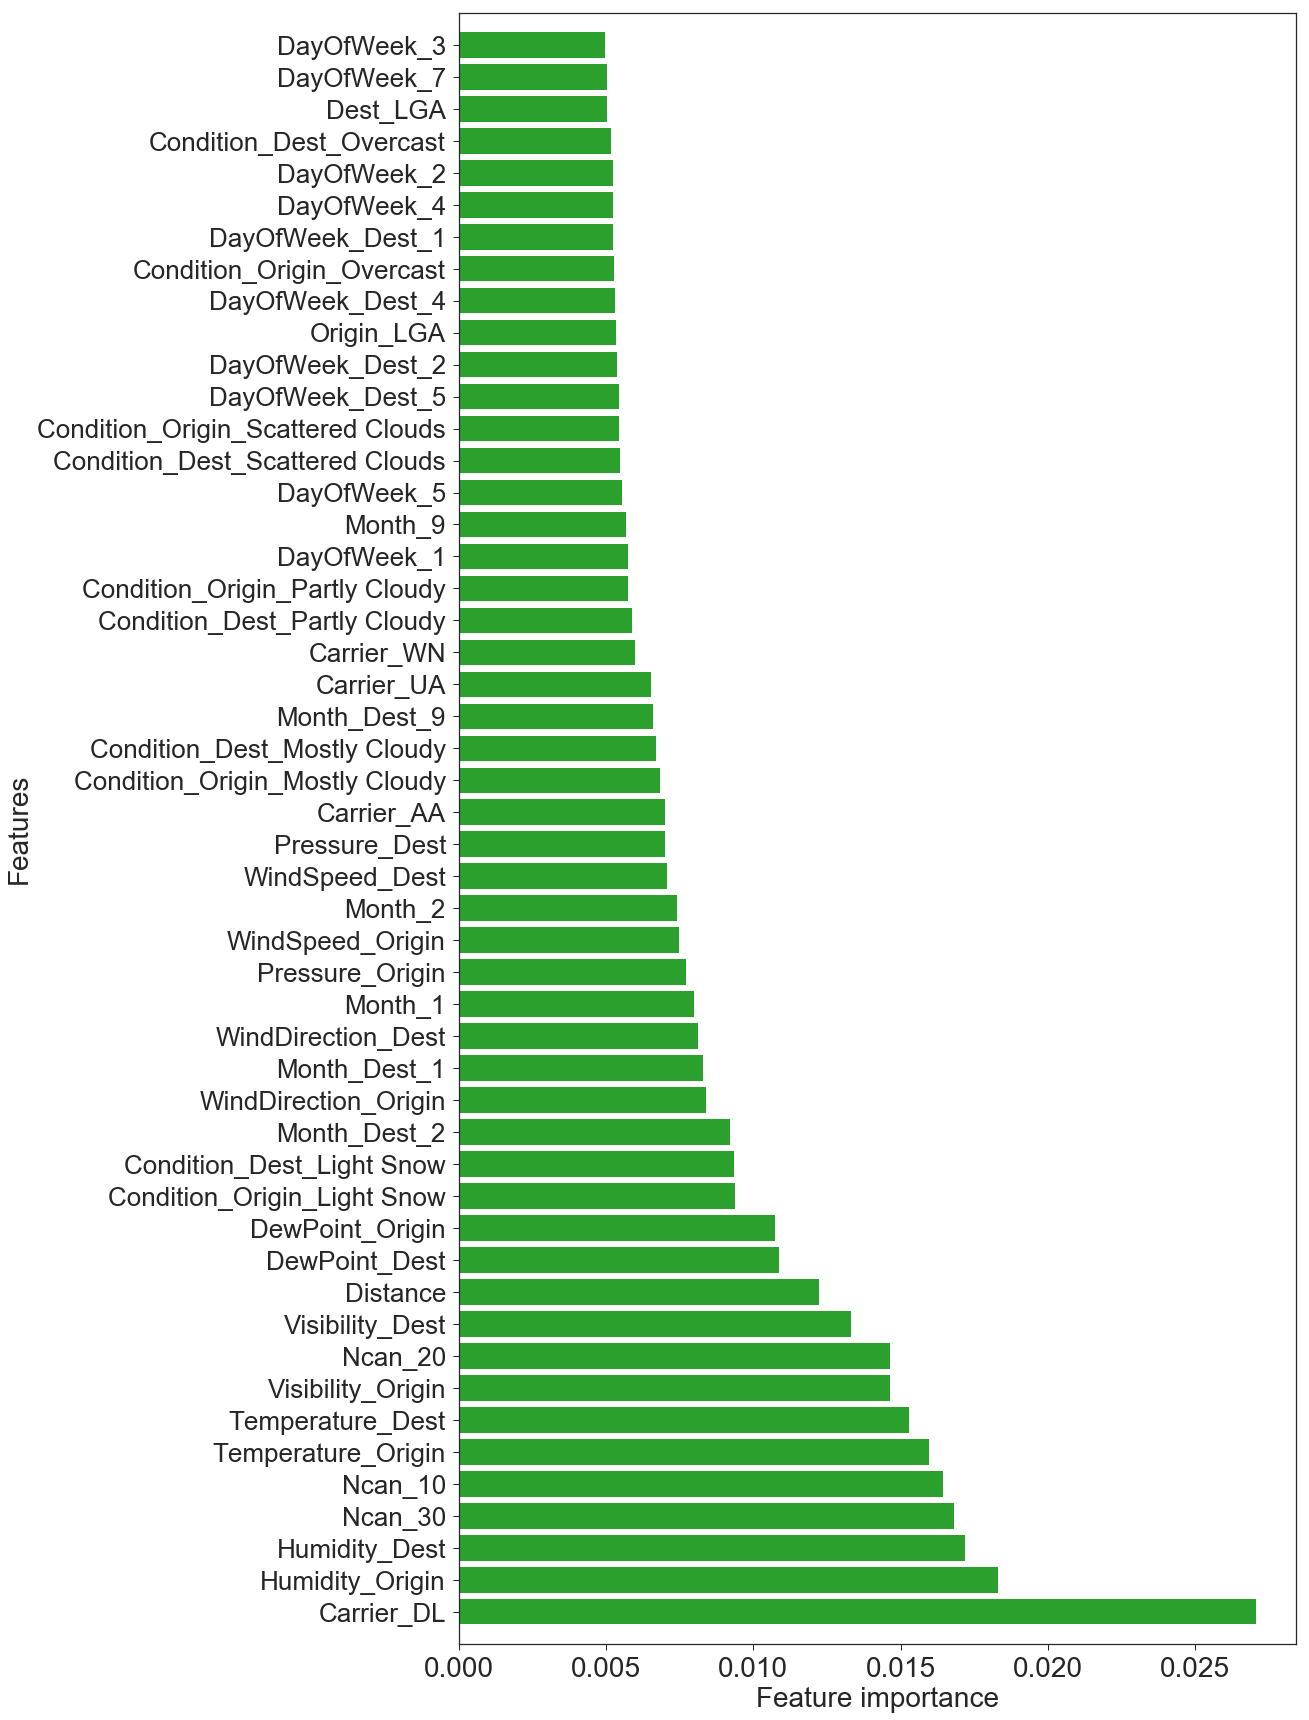

In [26]:
# Feature importance
imps = ETcw1.feature_importances_
# Std dev due to all trees
std = np.std([tree.feature_importances_ for tree in ETcw1.estimators_], axis=0)
# Index that sorts the features with most important first
indices = np.argsort(imps)[::-1]
# Original list of features
features = df.drop(["Cancelled"], axis=1).columns
for f in range(df.drop(["Cancelled"], axis=1).shape[1]):
    print(f+1, features[indices[f]], imps[indices[f]])

plt.figure(figsize=(15,30))
#plt.title("Feature importances: top 50")
nf = 50 # how many top features you want to visualize?
plt.barh(range(nf), imps[indices[:nf]], color=tableau20[4], align="center")
plt.yticks(range(nf), features[indices[:nf]], size=26)
plt.xlabel("Feature importance", fontsize=28)
plt.ylabel("Features", fontsize=28)
plt.xticks(size=28)
plt.ylim([-1, nf])
plt.show()

In [33]:
sfm = SelectFromModel(ETcw1, threshold=0.003, prefit=True)

In [34]:
X_select = sfm.transform(df.iloc[train_index].drop(["Cancelled"], axis=1))

In [35]:
X_select = pd.DataFrame(X_select)
X_select.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
0,2475.0,18.0,-4.0,36.0,4.5,33.0,23.0,7.0,0.0,32.0,-4.0,63.0,-4.0,50.0,19.0,7.0,0.0,48.0,-4.0,63.0,-12.5,50.0,18.5,7.0,0.0,55.9,54.0,93.0,11.5,110.0,2.0,30.16,62.1,48.9,62.0,12.7,270.0,10.0,29.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1773.0,10.0,6.0,132.0,6.0,133.0,15.5,5.0,0.0,20.0,9.5,147.0,12.0,140.0,18.0,5.0,0.0,29.0,8.0,147.0,9.0,140.0,18.0,6.0,0.0,80.1,57.9,47.0,6.9,60.0,10.0,30.03,87.1,70.0,57.0,4.6,110.0,10.0,29.85,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,746.0,9.0,-1.0,542.0,-10.0,531.0,15.0,6.0,0.0,18.0,-5.0,542.0,-17.5,531.0,14.0,7.0,0.0,26.0,-5.0,542.0,-18.0,531.0,13.0,7.0,0.0,70.0,44.1,39.0,5.8,0.0,10.0,30.17,66.9,62.1,84.0,10.4,90.0,9.0,30.08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,733.0,9.0,5.0,85.0,6.0,146.0,15.0,5.0,0.0,17.0,1.0,85.0,6.0,146.0,15.0,5.0,0.0,26.0,3.5,85.0,7.0,146.0,15.5,5.0,0.0,82.9,54.0,37.0,0.0,0.0,10.0,30.00,71.1,62.1,73.0,5.8,0.0,10.0,30.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,731.0,10.0,-3.0,59.0,-5.5,38.0,13.5,10.0,0.0,20.0,-3.0,59.0,-6.5,38.0,14.5,10.5,0.0,29.0,-2.0,59.0,-6.0,38.0,14.0,10.0,0.0,44.1,36.0,73.0,4.6,200.0,10.0,30.14,45.0,32.0,60.0,17.3,330.0,10.0,29.96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [36]:
Xs = X_select.values
ys = df.iloc[train_index].Cancelled.astype(int).values

In [37]:
sss1 = StratifiedKFold(n_splits=2, random_state=20)
i = 1
for train_index1, test_index1 in sss1.split(Xs, ys):
        Xs_train, Xs_test = Xs[train_index1], Xs[test_index1]
        ys_train, ys_test = ys[train_index1], ys[test_index1]
        print(i)
        print(Xs_train.shape, Xs_test.shape)
        print(ys_train.shape, ys_test.shape)
        ETcws = ExtraTreesClassifier(random_state=30, n_estimators = 100, min_samples_leaf=4, class_weight="balanced", n_jobs = 6)
        ETcws.fit(Xs_train, ys_train)
        print(average_precision_score(ys_test, ETcws.predict_proba(Xs_test)[:,1]))
        i = i + 1

1
(1071427, 116) (1071427, 116)
(1071427,) (1071427,)
0.333417982575
2
(1071427, 116) (1071427, 116)
(1071427,) (1071427,)


KeyboardInterrupt: 

In [44]:
Xs.shape

(2857139, 13)

In [45]:
Xs_train.shape

(1428570, 13)

In [39]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold

pr_auc_macro = []
pr_auc_er_macro = []

pr_auc_micro = []
pr_auc_er_micro = []

pr_auc_weighted = []
pr_auc_er_weighted = []

pr_auc_samples = []
pr_auc_er_samples = []

tharray = [0.0, 0.00001, 0.00002, 0.00005, 0.00007, 0.0001, 0.0002, 0.0005, 0.0007, 0.001, 0.0015, 0.00175, 0.002, 0.00225, 
           0.0025, 0.00275, 0.003, 0.00325, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02]
kf = 5
for th in tharray:
    pr_auc_th_macro = []
    pr_auc_th_micro = []
    pr_auc_th_weighted = []
    pr_auc_th_samples = []
    sfm = SelectFromModel(ETcw1, threshold=th, prefit=True)
    X_select = sfm.transform(df.iloc[train_index].drop(["Cancelled"], axis=1))
    X_select = pd.DataFrame(X_select)
    Xs = X_select.values
    ys = df.iloc[train_index].Cancelled.astype(int).values
    # k-fold splits
    sss1 = StratifiedKFold(n_splits=kf, random_state=20)
    for train_index1, test_index1 in sss1.split(Xs, ys):
        Xs_train, Xs_test = Xs[train_index1], Xs[test_index1]
        ys_train, ys_test = ys[train_index1], ys[test_index1]
        ETcws = ExtraTreesClassifier(random_state=30, n_estimators = 100, min_samples_leaf=4, class_weight="balanced", n_jobs = 7)
        ETcws.fit(Xs_train, ys_train)
        pr_auc_th_macro.append(average_precision_score(ys_test, ETcws.predict_proba(Xs_test)[:,1], average = 'macro'))
        pr_auc_th_micro.append(average_precision_score(ys_test, ETcws.predict_proba(Xs_test)[:,1], average = 'micro'))
        pr_auc_th_weighted.append(average_precision_score(ys_test, ETcws.predict_proba(Xs_test)[:,1], average = 'weighted'))
        pr_auc_th_samples.append(average_precision_score(ys_test, ETcws.predict_proba(Xs_test)[:,1], average = 'samples'))
    
    pr_auc_macro.append(np.mean(pr_auc_th_macro))
    pr_auc_er_macro.append(np.std(pr_auc_th_macro)/sqrt(kf))
    
    pr_auc_micro.append(np.mean(pr_auc_th_micro))
    pr_auc_er_micro.append(np.std(pr_auc_th_micro)/sqrt(kf))
    
    pr_auc_weighted.append(np.mean(pr_auc_th_weighted))
    pr_auc_er_weighted.append(np.std(pr_auc_th_weighted)/sqrt(kf))
    
    pr_auc_samples.append(np.mean(pr_auc_th_samples))
    pr_auc_er_samples.append(np.std(pr_auc_th_samples)/sqrt(kf))
    print("Threshold: ", th, "prauc: ", np.mean(pr_auc_th_macro))

Threshold:  0.0 prauc:  0.390089517951
Threshold:  1e-05 prauc:  0.390970471014
Threshold:  2e-05 prauc:  0.390911719895
Threshold:  5e-05 prauc:  0.389116035874
Threshold:  7e-05 prauc:  0.390989956785
Threshold:  0.0001 prauc:  0.389619743061
Threshold:  0.0002 prauc:  0.391023861309
Threshold:  0.0005 prauc:  0.392080361833
Threshold:  0.0007 prauc:  0.391309942102
Threshold:  0.001 prauc:  0.390792776854
Threshold:  0.0015 prauc:  0.390757101255
Threshold:  0.00175 prauc:  0.38595086603
Threshold:  0.002 prauc:  0.383458115562
Threshold:  0.00225 prauc:  0.381040450442
Threshold:  0.0025 prauc:  0.369352446364
Threshold:  0.00275 prauc:  0.361365928918
Threshold:  0.003 prauc:  0.35488528172
Threshold:  0.00325 prauc:  0.347134651033
Threshold:  0.0035 prauc:  0.332675732432
Threshold:  0.004 prauc:  0.325887621931
Threshold:  0.0045 prauc:  0.320762051212
Threshold:  0.005 prauc:  0.31550141709
Threshold:  0.0055 prauc:  0.298499394619
Threshold:  0.006 prauc:  0.283566857054
Thre

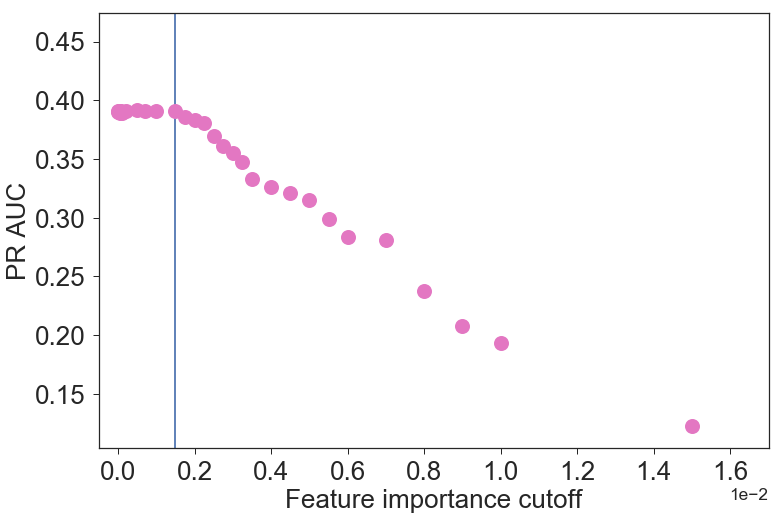

In [59]:
df_th = pd.DataFrame(OrderedDict({"Thresholds": tharray,
                     "PR AUC MACRO": pr_auc_macro, "PR AUC MACRO ER": pr_auc_er_macro, "PR AUC MICRO": pr_auc_micro,
                                 "PR AUC MICRO ER": pr_auc_er_micro, "PR AUC WEIGHTED": pr_auc_weighted,
                                 "PR AUC WEIGHTED ER": pr_auc_er_weighted, "PR AUC SAMPLES": pr_auc_samples,
                                 "PR AUC SAMPLES ER": pr_auc_er_samples}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.errorbar(df_th.Thresholds, df_th["PR AUC MACRO"], df_th["PR AUC MACRO ER"], color=tableau20[12], fmt='o', markersize=15)
#ax1.errorbar(df_th.Thresholds, df_th["PR AUC MICRO"], df_th["PR AUC MICRO ER"], color=tableau20[14], fmt='o', markersize=15)
#ax1.errorbar(df_th.Thresholds, df_th["PR AUC WEIGHTED"], df_th["PR AUC WEIGHTED ER"], color=tableau20[16], fmt='o', markersize=15)
#ax1.errorbar(df_th.Thresholds, df_th["PR AUC SAMPLES"], df_th["PR AUC SAMPLES ER"], color=tableau20[18], fmt='o', markersize=15)

ax1.set_ylabel("PR AUC", size=26)
plt.xticks(fontsize=26)
plt.xlabel("Feature importance cutoff", size=26)
ax1.tick_params('y', labelsize=26)
plt.xlim([-0.0005, 0.017])
#ax1.set_xscale('log')
plt.axvline(0.0015)
pylab.ticklabel_format(axis='x',style='sci',scilimits=(1,20))

In [89]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold
sfm = SelectFromModel(ETcw, threshold=0.01, prefit=True)

In [79]:
X_select = sfm.estimator.transform(df.drop(["Cancelled"], axis=1))
X_select = pd.DataFrame(X_select)
Xs = X_select.values
ys = df.Cancelled.astype(int).values

//anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [80]:
Xs.shape

(2857139, 31)

In [90]:
sss1 = StratifiedKFold(n_splits=5, random_state=20)

In [91]:
for train_index, test_index in sss1.split(Xs, ys):
    print("hello")

hello
hello
hello
hello
hello


In [356]:
import time
from sklearn.metrics import average_precision_score
PRAUC_macro = []
PRAUC_micro = []
PRAUC_weighted = []
PRAUC_samples = []
CompTime = []
for trees in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    t0 = time.process_time()
    ETcwiter = ExtraTreesClassifier(random_state=40, n_estimators = trees, min_samples_leaf=4, class_weight="balanced")
    ETcwiter.fit(X_train, y_train)
    PRAUC_macro.append(average_precision_score(y_test, ETcwiter.predict_proba(X_test)[:,1]))
    PRAUC_micro.append(average_precision_score(y_test, ETcwiter.predict_proba(X_test)[:,1], average = 'micro'))
    PRAUC_weighted.append(average_precision_score(y_test, ETcwiter.predict_proba(X_test)[:,1], average = 'weighted'))
    PRAUC_samples.append(average_precision_score(y_test, ETcwiter.predict_proba(X_test)[:,1], average = 'samples'))
    print(trees)
    print("Elapsed time: ", time.process_time() - t0)
    CompTime.append((time.process_time() - t0)/60)

TypeError: append() takes no keyword arguments

In [329]:
ET_final = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced",
                               n_jobs=7, oob_score = True, bootstrap=True)
ET_final.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=7,
           oob_score=True, random_state=40, verbose=0, warm_start=False)

#####################
Test data
#####################
F1:  0.330264411084
Cohen Kappa:  0.326306073039
Brier:  0.0103369103369
LogLoss:  0.0790281026385
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   1412160
          1       0.65      0.22      0.33     16410

avg / total       0.99      0.99      0.99   1428570



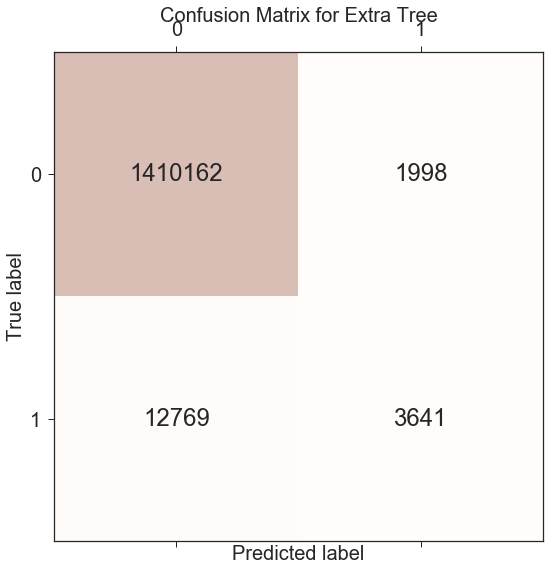

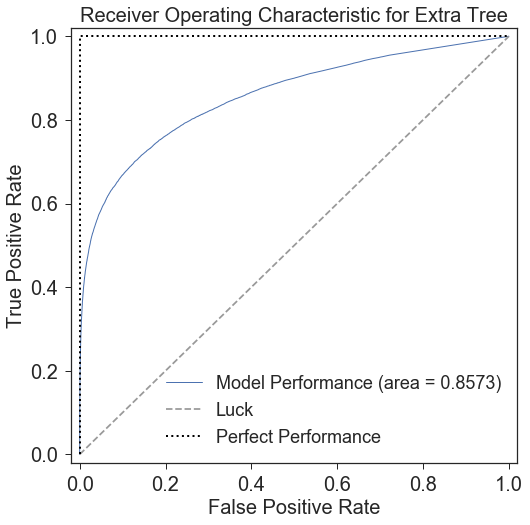

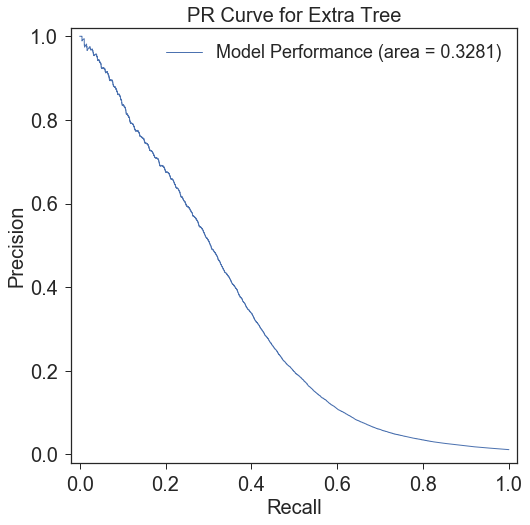

In [330]:
result(ET_final, X_train, y_train, X_test, y_test, train_result=False, clf_name="Extra Tree")

## Using undersampling on training data, no class_weight: Maximize PR AUC

In [47]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as pl
from imblearn.under_sampling import RandomUnderSampler
# Steps for pipeline
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("model", ExtraTreesClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__n_estimators = [50],
                  model__max_features = ['sqrt', 'log2'],
                  model__bootstrap = [True, False],
                 model__min_samples_leaf = [1, 3, 5])
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
ETrusPR = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 3,
                           cv = cv,
                          n_jobs=-1,
                          scoring='average_precision',
                          iid=False)
# Training using CV
ETrusPR.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=3, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=3, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=3, model__n_estimators=50 
[CV]  model__bootstrap=True, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimato

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min


[CV] model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=3, model__n_estimators=50 
[CV]  model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, score=0.229478, total=  13.4s
[CV] model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=3, model__n_estimators=50 
[CV]  model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, score=0.220387, total=  13.0s
[CV]  model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=3, model__n_estimators=50, score=0.224860, total=  11.7s
[CV]  model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=3, model__n_estimators=50, score=0.221959, total=  11.7s
[CV] model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=50 
[CV] model__bootstrap=True, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=50 
[CV]  model__bootstrap=True, model__

[CV] model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=50 
[CV] model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=50 
[CV] model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=50 
[CV]  model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, score=0.220882, total=  16.5s
[CV]  model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=3, model__n_estimators=50, score=0.222401, total=  13.9s
[CV]  model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, score=0.228951, total=  16.3s
[CV] model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=5, model__n_estimators=50 
[CV]  model__bootstrap=False, model__max_features=log2, model__min_samples_leaf=3, model__n_estimators=50, score=0.234690, total=  14.1s
[CV]  model__bootstrap=False

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.3min finished


CPU times: user 1min 8s, sys: 4.76 s, total: 1min 13s
Wall time: 4min 22s


In [48]:
ETrusPR.best_params_

{'model__bootstrap': False,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 3,
 'model__n_estimators': 50}

#####################
Test data
#####################
F1:  0.0890709365109
Cohen Kappa:  0.0689888645841
Brier:  0.171241171241
LogLoss:  0.464625402252
             precision    recall  f1-score   support

          0       1.00      0.83      0.91   1412160
          1       0.05      0.73      0.09     16410

avg / total       0.99      0.83      0.90   1428570



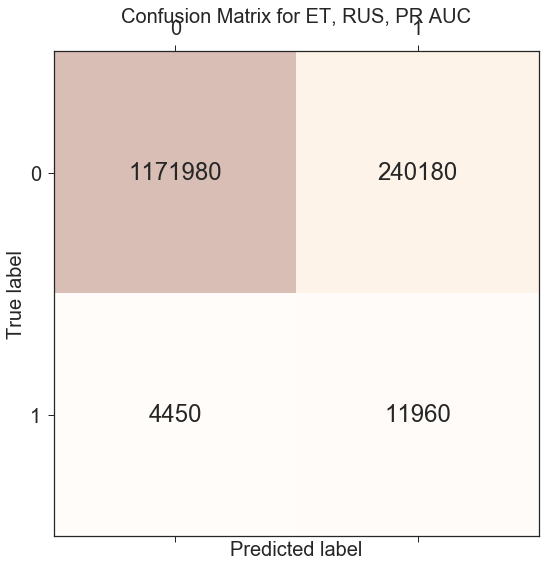

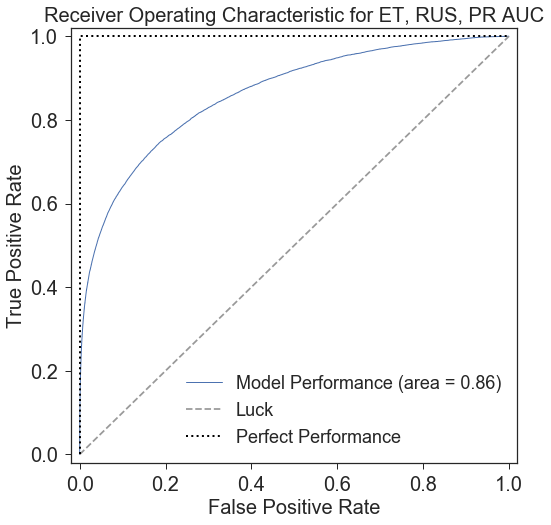

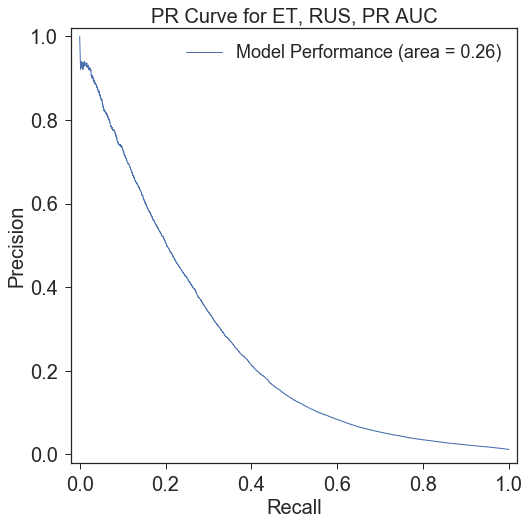

In [49]:
result(ETrusPR, X_train, y_train, X_test, y_test, train_result=False, clf_name="ET, RUS, PR AUC")

We have tried RUS so far and got PR AUC = 0.26. We can try different sapmling techniques and also use class_weight parameter in RF classfier to see if any of these improve the PR AUC. 

## No under or over sampling, using class_weight

In [51]:
%%time
# Steps for pipeline
steps = [("model", ExtraTreesClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__n_estimators = [50],
                  model__max_features = ['sqrt', 'log2'],
                  model__min_samples_leaf = [1, 4, 7, 10, 13],
                 model__class_weight = ['balanced'])
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
ETcw = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 3,
                           cv = cv,
                          n_jobs=-1,
                          scoring='average_precision',
                          iid=False)
# Training using CV
ETcw.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50 
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50 
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50 
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50 
[CV]  model__class_weight=balanced, model__

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 19.4min


[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=13, model__n_estimators=50 
[CV]  model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, score=0.313146, total= 9.0min
[CV] model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=13, model__n_estimators=50 
[CV]  model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, score=0.312531, total= 8.9min
[CV] model__class_weight=balanced, model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50 
[CV]  model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, score=0.297720, total= 9.0min
[CV] model__class_weight=balanced, model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50 
[CV]  model__class_weight=balanced, model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, scor

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 56.7min finished


CPU times: user 4min 53s, sys: 12.3 s, total: 5min 6s
Wall time: 1h 42s


In [52]:
ETcw.best_params_

{'model__class_weight': 'balanced',
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__n_estimators': 50}

#####################
Test data
#####################
F1:  0.360427625997
Cohen Kappa:  0.355931828168
Brier:  0.0105532105532
LogLoss:  0.0779208555744
             precision    recall  f1-score   support

          0       0.99      1.00      0.99   1412160
          1       0.59      0.26      0.36     16410

avg / total       0.99      0.99      0.99   1428570



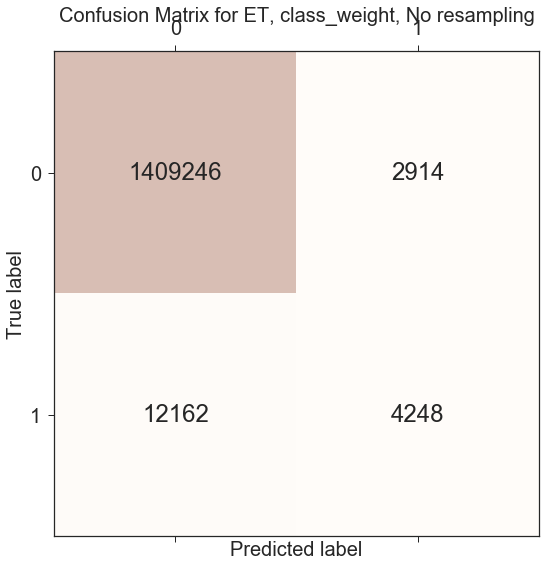

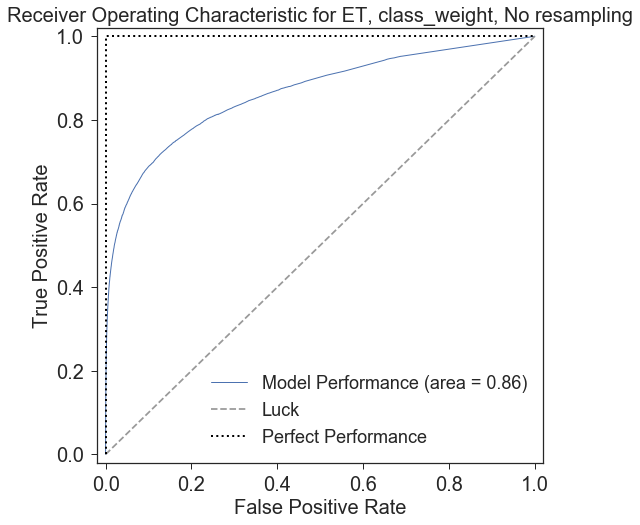

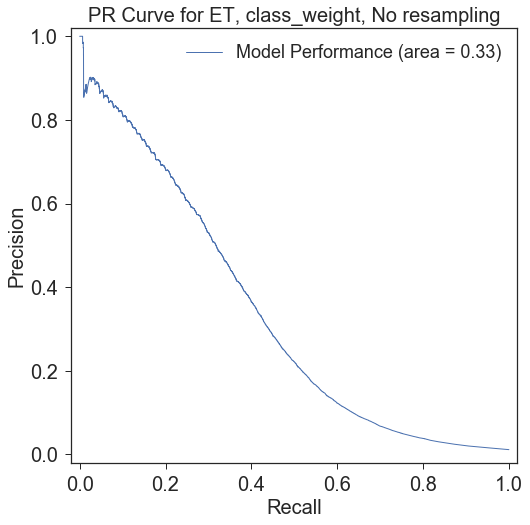

In [54]:
result(ETcw, X_train, y_train, X_test, y_test, train_result=False, clf_name="ET, class_weight, No resampling")

The model with "No under or over sampling, using class_weight" is the best so far with PR AUC = 0.33. Can we get even better? Lets try SMOTEing.

## SMOTE, PR AUC

In [55]:
%%time
from imblearn.over_sampling import SMOTE
# Steps for pipeline
steps = [("smote", SMOTE(random_state=30)),
         ("model", ExtraTreesClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(smote__kind = ['regular', 'borderline1', 'borderline2'],
                  model__n_estimators = [50],
                  model__max_features = ['sqrt', 'log2'],
                  model__min_samples_leaf = [1, 4, 7, 10, 13]
                  )
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
ETsmote = GridSearchCV(pipe, param_grid = param_grid, 
                           verbose = 4,
                           cv = cv,
                          n_jobs=7,
                          scoring='average_precision',
                          iid=False)
# Training using CV
ETsmote.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=regular 
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=regular 
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=regular 
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=regular 
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=regular 
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline1 
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=regular, score=0.273688, total=17.2min
[CV] model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimato

[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed: 36.9min


[CV] model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2, score=0.269575, total=17.5min
[CV] model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2, score=0.246136, total=17.6min
[CV] model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=sqrt, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2, score=0.239207, total=17.8min
[CV] model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=sqrt, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular, score=0.298315, total=16.5min
[CV] model__max_features=sqrt, model

[CV] model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=sqrt, model__min_samples_leaf=7, model__n_estimators=50, smote__kind=borderline2, score=0.242409, total=17.1min
[CV] model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=sqrt, model__min_samples_leaf=7, model__n_estimators=50, smote__kind=borderline2, score=0.240919, total=17.4min
[CV] model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=regular, score=0.271885, total=16.5min
[CV] model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=sqrt, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=regular, score=0.263966, total=16.3min
[CV] model__max_featur

[CV] model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2 
[CV]  model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=regular, score=0.264848, total=14.2min
[CV] model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2 
[CV]  model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline1, score=0.289587, total=14.8min
[CV] model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2 
[CV]  model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline1, score=0.279423, total=14.8min
[CV] model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2 
[CV]  model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline1, score=0.258038, total=14.5min
[CV] model__max_features

[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed: 210.7min


[CV] model__max_features=log2, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline1, score=0.272952, total=14.3min
[CV] model__max_features=log2, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2, score=0.257910, total=14.8min
[CV] model__max_features=log2, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=log2, model__min_samples_leaf=1, model__n_estimators=50, smote__kind=borderline2, score=0.261916, total=14.9min
[CV] model__max_features=log2, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=log2, model__min_samples_leaf=4, model__n_estimators=50, smote__kind=regular, score=0.287675, total=14.0min
[CV] model__max_features=log2, model__mi

[CV] model__max_features=log2, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=regular 
[CV]  model__max_features=log2, model__min_samples_leaf=7, model__n_estimators=50, smote__kind=borderline2, score=0.229792, total=14.5min
[CV] model__max_features=log2, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=log2, model__min_samples_leaf=7, model__n_estimators=50, smote__kind=borderline2, score=0.234966, total=14.1min
[CV] model__max_features=log2, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=log2, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=regular, score=0.270597, total=13.4min
[CV] model__max_features=log2, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=borderline1 
[CV]  model__max_features=log2, model__min_samples_leaf=10, model__n_estimators=50, smote__kind=regular, score=0.283187, total=13.3min
[CV] model__max_features=l

[Parallel(n_jobs=7)]: Done 150 out of 150 | elapsed: 348.3min finished


CPU times: user 10min 50s, sys: 1min 14s, total: 12min 5s
Wall time: 5h 56min 12s


In [56]:
ETsmote.best_params_

{'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__n_estimators': 50,
 'smote__kind': 'regular'}

#####################
Test data
#####################
F1:  0.353337874659
Cohen Kappa:  0.346717973918
Brier:  0.0132902132902
LogLoss:  0.106705670298
             precision    recall  f1-score   support

          0       0.99      0.99      0.99   1412160
          1       0.40      0.32      0.35     16410

avg / total       0.99      0.99      0.99   1428570



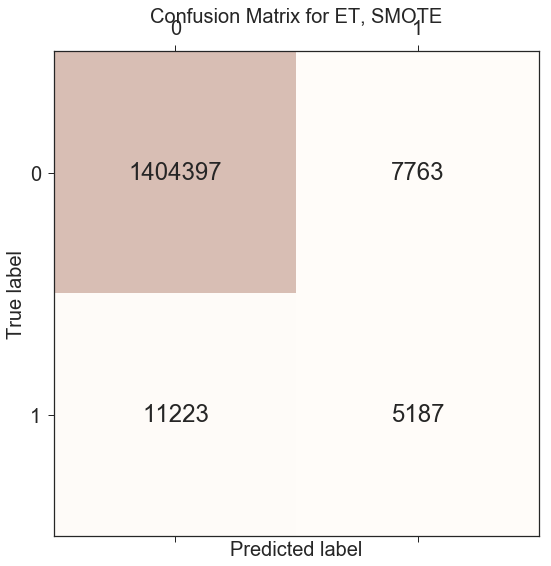

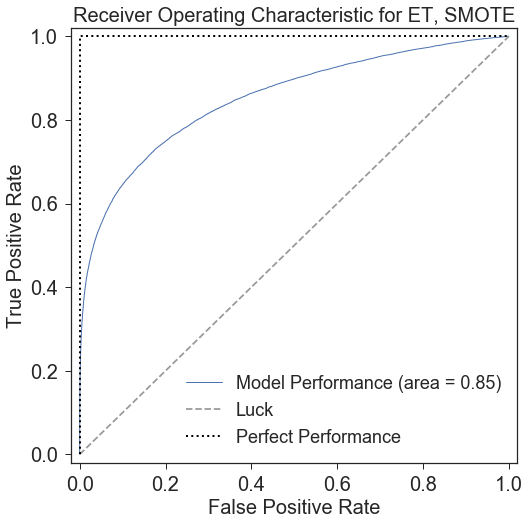

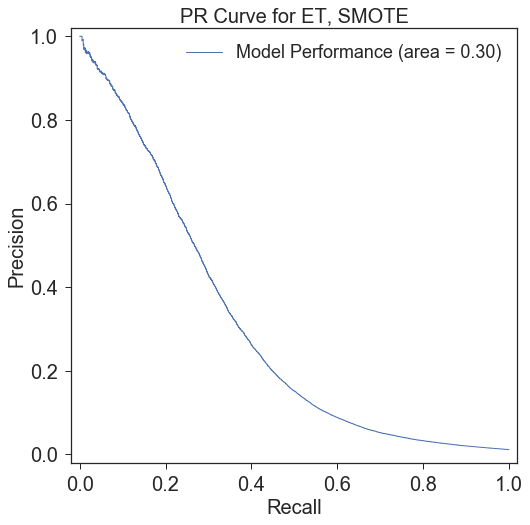

In [57]:
result(ETsmote, X_train, y_train, X_test, y_test, train_result=False, clf_name="ET, SMOTE")

SMOTEing did not help, so the best option is not to use any resampling technique and go with simply weighting the classes using "class_weight = balanced". 


In order to improve further, we can increase the number of trees in the random forest. However, the computational cost will go up by doing so. We can play with the trade-off and pick the number of trees such that beyond that number the PR AUC does not increase much. 

In [58]:
import time
from sklearn.metrics import average_precision_score
PRAUC = []
CompTime = []
for trees in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    t0 = time.process_time()
    ETcwiter = ExtraTreesClassifier(random_state=40, n_estimators = trees, min_samples_leaf=4, class_weight="balanced")
    ETcwiter.fit(X_train, y_train)
    PRAUC.append(average_precision_score(y_test, ETcwiter.predict_proba(X_test)[:,1]))
    print(trees)
    print("Elapsed time: ", time.process_time() - t0)
    CompTime.append((time.process_time() - t0)/60)

10
Elapsed time:  51.031242999999904
20
Elapsed time:  99.73401100000024
30
Elapsed time:  148.24772099999996
40
Elapsed time:  199.45192099999986
50
Elapsed time:  246.505672
60
Elapsed time:  295.183998
70
Elapsed time:  352.42432800000006
80
Elapsed time:  397.73019899999963
90
Elapsed time:  448.73362799999995
100
Elapsed time:  503.55574999999953


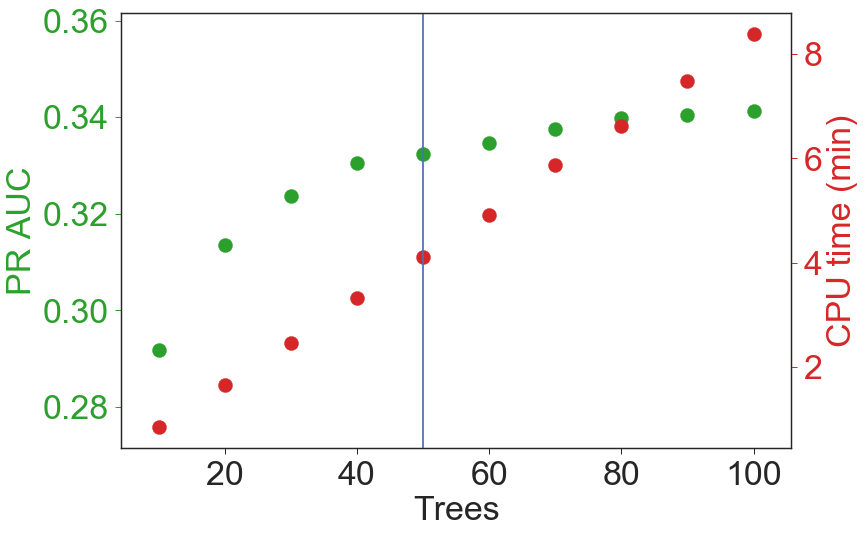

In [59]:
df_rf = pd.DataFrame(OrderedDict({"Trees": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                     "PR AUC": PRAUC, "CPU Time": CompTime}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(df_rf.Trees, df_rf["PR AUC"], color=tableau20[4], s=200)
ax1.set_ylabel("PR AUC", size=34, color=tableau20[4])
plt.xticks(fontsize=34)
plt.xlabel("Trees", size=34)
ax1.tick_params('y', colors=tableau20[4], labelsize=34)

ax2 = ax1.twinx()
ax2.scatter(df_rf.Trees, df_rf["CPU Time"], color=tableau20[6], s=200)
ax2.set_ylabel("CPU time (min)", size=34, color=tableau20[6])
ax2.tick_params('y', colors=tableau20[6], labelsize = 34)

plt.axvline(50)

Clearly, the PR AUC improves by increasing the number of trees but at the cost of computational time. The PR AUC  seems to be leveling off asymptotically after around 40-50 trees. In other words, for more than 50 trees, the gain in PR AUC is not as significant as the increase in computational cost is. So, ***we will stick with 50 trees***.

With 50 trees, and all other optimized hyper-parameters, is there anything else that we can do to improve PR AUC? We can try to play with feature selections which is one of a by products of the random forest model. Let's first explore the feature importance that the random forest model provides.

## Feature Importance

In [24]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
ETcw = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced")
ETcw.fit(X_train, y_train)

CPU times: user 3min 55s, sys: 1.81 s, total: 3min 57s
Wall time: 3min 57s


1 Month_Dest 0.0391940132109
2 Month 0.0374810449452
3 Humidity_Origin 0.0362267127541
4 Humidity_Dest 0.0354580577204
5 Ncan_30 0.0328463098092
6 Temperature_Dest 0.0318848630297
7 Carrier 0.0305059614142
8 DayOfMonth_Dest 0.028805769893
9 Temperature_Origin 0.0284089925915
10 DayofMonth 0.027914204649
11 Ncan_20 0.0268207659365
12 DewPoint_Origin 0.026140772542
13 Visibility_Origin 0.0261048543829
14 Distance 0.0247273064199
15 DewPoint_Dest 0.0244257599681
16 Visibility_Dest 0.0239193213899
17 DayOfWeek 0.0237454842542
18 DayOfWeek_Dest 0.0236808502148
19 Ncan_10 0.0230050176143
20 Origin 0.0214384026612
21 Dest 0.021314507288
22 WindDirection_Origin 0.0212981330925
23 WindSpeed_Origin 0.0201280246976
24 WindDirection_Dest 0.0201258368629
25 Condition_Origin 0.0180745682137
26 WindSpeed_Dest 0.0179138209054
27 Condition_Dest 0.0176868756806
28 Pressure_Origin 0.0176689957528
29 CRSDepHr 0.0173578534759
30 Pressure_Dest 0.0165263893295
31 CRSArrHr 0.0161383441131
32 ArrDelayMax_10 0.

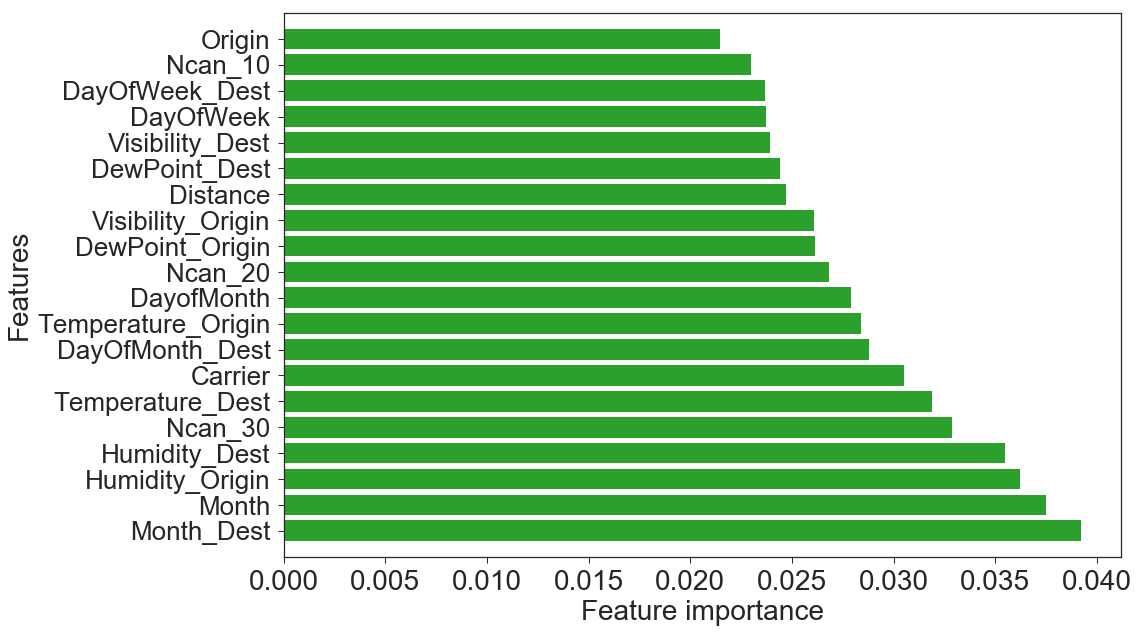

In [27]:
# Feature importance
#forest = RFcw.best_estimator_.steps[-1][1] 
imps = ETcw.feature_importances_
# Std dev due to all trees in the forest
std = np.std([tree.feature_importances_ for tree in ETcw.estimators_], axis=0)
# Index that sorts the features with most important first
indices = np.argsort(imps)[::-1]
# Original list of features
features = df.drop(["Cancelled"], axis=1).columns
for f in range(df.drop(["Cancelled"], axis=1).shape[1]):
    print(f+1, features[indices[f]], imps[indices[f]])

plt.figure(figsize=(15,10))
#plt.title("Feature importances: top 50")
nf = 20 # how many top features you want to visualize?
plt.barh(range(nf), imps[indices[:nf]], color=tableau20[4], align="center")
plt.yticks(range(nf), features[indices[:nf]], size=26)
plt.xlabel("Feature importance", fontsize=28)
plt.ylabel("Features", fontsize=28)
plt.xticks(size=28)
plt.ylim([-1, nf])
plt.show()

## Selecting top features and trying again...

In [26]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import average_precision_score
pr_auc = []
tharray = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.015, 0.02, 0.025, 0.03]
for th in tharray:
    sfm = SelectFromModel(ETcw, threshold=th, prefit=True)
    X_select = sfm.transform(df.drop(["Cancelled"], axis=1))
    X_select = pd.DataFrame(X_select)
    Xs = X_select.values
    ys = df.Cancelled.astype(int).values
    # 50% split
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=20)
    for train_index, test_index in sss1.split(Xs, ys):
        Xs_train, Xs_test = Xs[train_index], Xs[test_index]
        ys_train, ys_test = ys[train_index], ys[test_index]
    ETcws = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced")
    ETcws.fit(Xs_train, ys_train)
    print(th)
    pr_auc.append(average_precision_score(ys_test, ETcws.predict_proba(Xs_test)[:,1]))

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.015
0.02
0.025
0.03


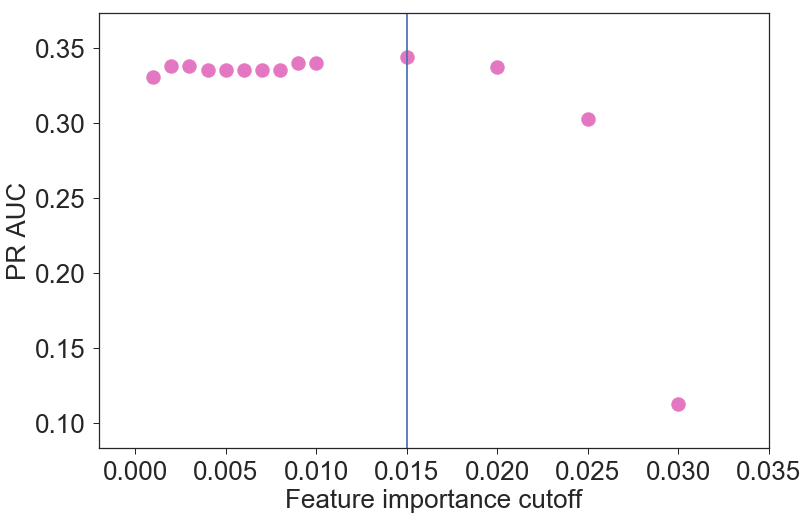

In [30]:
df_th = pd.DataFrame(OrderedDict({"Thresholds": tharray,
                     "PR AUC": pr_auc}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(df_th.Thresholds, df_th["PR AUC"], color=tableau20[12], s=200)
ax1.set_ylabel("PR AUC", size=26)
plt.xticks(fontsize=26)
plt.xlabel("Feature importance cutoff", size=26)
ax1.tick_params('y', labelsize=26)
plt.xlim([-0.002, 0.035])
plt.axvline(0.015)

We tried to remove different set of features using different threshold values of feature importances. We find that the PR AUC is almost constant when threshold is less than 0.02. To minimize computational cost by maintaining the PR AUC, we chhose threshold to be 0.015. 

Lets delete all those features permanently from the data frame that were not useful in terms of achieving higher PR AUC. There is one more item that we have not yet tried, and that is one hot encoding. We should have done it in the beginning but luckily there is no problem because all the features that we removed so far are either binary or numerical. In one-hot encoding (OHE) we need to worry about only categorical variables. Let's try doing OHE and see if that improves PR AUC. Before doing this, we will restart, i.e. clear all variables and load the data again, and then remove some features and then will do OHE. 

In [65]:
# Cleaning many variables
del df
del X
del y
del X_train
del X_test
del tmp
del train_index
del test_index

In [66]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [67]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.shape

(2857139, 68)

In [68]:
# Removing features that have feature importance values less than 0.009
drop_them = ["ArrDelayMax_10", "DepDelayMax_10", "TaxiOutMedian_30", "TaxiOutMedian_20", "ArrDelayMax_20", 
             "ArrDelayMedian_10", "TaxiInMedian_30", "ArrDelayMedian_30", "DepDelayMax_20", "TaxiOutMedian_10",
             "TaxiInMedian_20", "ArrDelayMax_30", "ArrDelayMedian_20", "Nflights_30", "DepDelayMax_30", 
             "TaxiInMedian_10", "Nflights_20", "DepDelayMedian_30", "Nflights_10", "DepDelayMedian_20", 
             "DepDelayMedian_10", "Ndiv_30", "Ndiv_20", "Ndiv_10", "AllCanceled_10", "AllCanceled_20", 
             "AllCanceled_30", "TempFlight_10", "TempFlight_20", "TempFlight_30", "AllCanDiv_10", "AllCanDiv_30",
             "AllDiverted_30", "AllDiverted_20", "AllCanDiv_20", "AllDiverted_10"]
df.drop(drop_them, axis=1, inplace=True)

In [69]:
numvar = ["Distance", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "DepDelayMedian_20", 
          "DepDelayMax_20", "ArrDelayMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", 
          "DepDelayMax_30", "ArrDelayMedian_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest"]
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
binvar = ["TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllCanceled_20", "AllCanceled_10"]

## One hot encoding

In [70]:
for cvar in catvar:
    df = pd.concat([df, pd.get_dummies(df[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df.drop([cvar], axis=1, inplace=True)

In [71]:
X = df.drop(["Cancelled"], axis=1).values
y = df.Cancelled.astype(int).values

In [74]:
df.shape

(2857139, 295)

In [72]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=10)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#####################
Test data
#####################
F1:  0.414395460776
Cohen Kappa:  0.407908245284
Brier:  0.0128597128597
LogLoss:  0.0817304745386
             precision    recall  f1-score   support

          0       0.99      0.99      0.99   1412160
          1       0.43      0.40      0.41     16410

avg / total       0.99      0.99      0.99   1428570

CPU times: user 26min 13s, sys: 14.7 s, total: 26min 28s
Wall time: 4min 15s


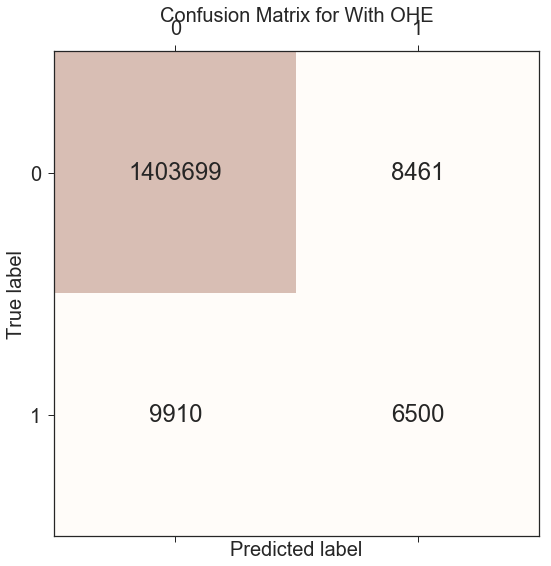

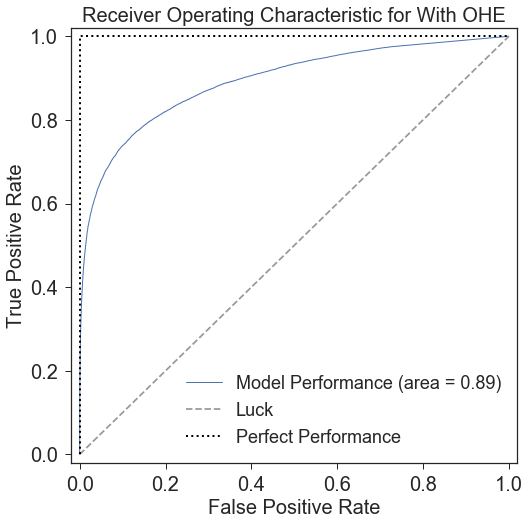

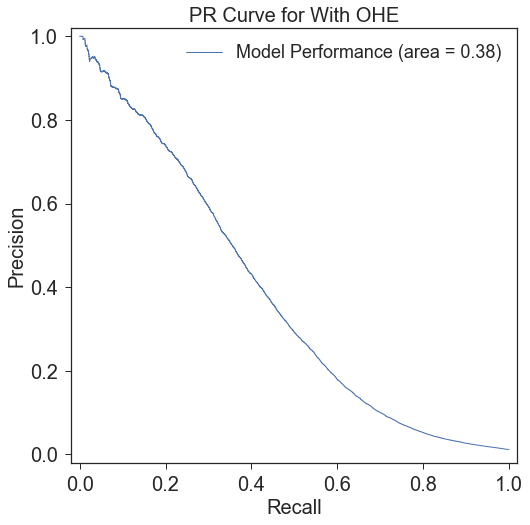

In [73]:
%%time
ETcw_ohe = ExtraTreesClassifier(random_state=40, n_estimators = 100, min_samples_leaf=4, class_weight="balanced",
                               n_jobs=7)
ETcw_ohe.fit(X_train, y_train)
result(ETcw_ohe, X_train, y_train, X_test, y_test, train_result=False, clf_name="With OHE")

Since OHE works best so far, lets again see if increasing the number of trees helps.

In [75]:
import time
from sklearn.metrics import average_precision_score
PRAUC = []
CompTime = []
for trees in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    t0 = time.process_time()
    ETcwiter1 = ExtraTreesClassifier(random_state=40, n_estimators = trees, min_samples_leaf=4, class_weight="balanced")
    ETcwiter1.fit(X_train, y_train)
    PRAUC.append(average_precision_score(y_test, ETcwiter1.predict_proba(X_test)[:,1]))
    print(trees)
    print("Elapsed time: ", time.process_time() - t0)
    CompTime.append((time.process_time() - t0)/60)

10
Elapsed time:  142.38528900000165
20
Elapsed time:  257.8045890000012
30
Elapsed time:  387.4846230000003
40
Elapsed time:  511.07027200000084
50
Elapsed time:  671.0095939999992
60
Elapsed time:  789.757372
70
Elapsed time:  971.6520180000007
80
Elapsed time:  1095.1497499999987
90
Elapsed time:  1227.957942000001
100
Elapsed time:  1410.7327600000008


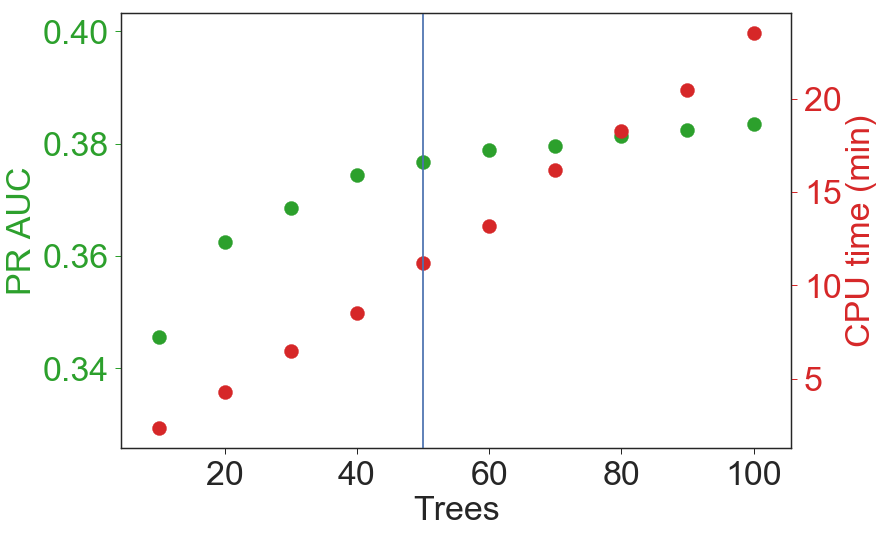

In [76]:
df_rf = pd.DataFrame(OrderedDict({"Trees": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                     "PR AUC": PRAUC, "CPU Time": CompTime}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(df_rf.Trees, df_rf["PR AUC"], color=tableau20[4], s=200)
ax1.set_ylabel("PR AUC", size=34, color=tableau20[4])
plt.xticks(fontsize=34)
plt.xlabel("Trees", size=34)
ax1.tick_params('y', colors=tableau20[4], labelsize=34)

ax2 = ax1.twinx()
ax2.scatter(df_rf.Trees, df_rf["CPU Time"], color=tableau20[6], s=200)
ax2.set_ylabel("CPU time (min)", size=34, color=tableau20[6])
ax2.tick_params('y', colors=tableau20[6], labelsize = 34)

plt.axvline(50)

We find that 50 is a good chice. So, we finalize the ET model with the following items:

***
1. Ntrees: 50

2. min_samples_leaf: 4

3. class_weight: "balanced"

4. One-hot encoding: Yes

5. Any resampling: No

6. Remove features: ["ArrDelayMax_10", "DepDelayMax_10", "TaxiOutMedian_30", "TaxiOutMedian_20", "ArrDelayMax_20", 
     "ArrDelayMedian_10", "TaxiInMedian_30", "ArrDelayMedian_30", "DepDelayMax_20", "TaxiOutMedian_10",
     "TaxiInMedian_20", "ArrDelayMax_30", "ArrDelayMedian_20", "Nflights_30", "DepDelayMax_30", 
     "TaxiInMedian_10", "Nflights_20", "DepDelayMedian_30", "Nflights_10", "DepDelayMedian_20", 
     "DepDelayMedian_10", "Ndiv_30", "Ndiv_20", "Ndiv_10", "AllCanceled_10", "AllCanceled_20", 
     "AllCanceled_30", "TempFlight_10", "TempFlight_20", "TempFlight_30", "AllCanDiv_10", "AllCanDiv_30",
     "AllDiverted_30", "AllDiverted_20", "AllCanDiv_20", "AllDiverted_10"]
***

Lets, once again, clear all variables, and start from scratch to get the final RF model.

In [77]:
del df
del X
del y
del X_train
del X_test
del train_index
del test_index

## Final Iteration

In [78]:
df = pd.read_csv("../Data/ExploredDataCleaned/FlightHistory_Weather_Jan2015-Dec2016_Top20Airports_Window60mins_ExploredCleaned.csv")

In [79]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [80]:
# Removing features that have feature importance values less than 0.009
drop_them = ["ArrDelayMax_10", "DepDelayMax_10", "TaxiOutMedian_30", "TaxiOutMedian_20", "ArrDelayMax_20", 
             "ArrDelayMedian_10", "TaxiInMedian_30", "ArrDelayMedian_30", "DepDelayMax_20", "TaxiOutMedian_10",
             "TaxiInMedian_20", "ArrDelayMax_30", "ArrDelayMedian_20", "Nflights_30", "DepDelayMax_30", 
             "TaxiInMedian_10", "Nflights_20", "DepDelayMedian_30", "Nflights_10", "DepDelayMedian_20", 
             "DepDelayMedian_10", "Ndiv_30", "Ndiv_20", "Ndiv_10", "AllCanceled_10", "AllCanceled_20", 
             "AllCanceled_30", "TempFlight_10", "TempFlight_20", "TempFlight_30", "AllCanDiv_10", "AllCanDiv_30",
             "AllDiverted_30", "AllDiverted_20", "AllCanDiv_20", "AllDiverted_10"]
df.drop(drop_them, axis=1, inplace=True)
numvar = ["Distance", "DepDelayMedian_10", "DepDelayMax_10", "ArrDelayMedian_10",
          "TaxiOutMedian_10", "TaxiInMedian_10", "Ncan_10", "Ndiv_10", "DepDelayMedian_20", 
          "DepDelayMax_20", "ArrDelayMedian_20", "Ncan_20", "Ndiv_20", "Nflights_30", "DepDelayMedian_30", 
          "DepDelayMax_30", "ArrDelayMedian_30", "TaxiOutMedian_30", "TaxiInMedian_30", "Ncan_30", 
          "Ndiv_30", "Temperature_Origin", "DewPoint_Origin", "Humidity_Origin", "WindSpeed_Origin", 
          "WindDirection_Origin", "Visibility_Origin", "Pressure_Origin", "Temperature_Dest", "DewPoint_Dest",
          "Humidity_Dest", "WindSpeed_Dest", "WindDirection_Dest", "Visibility_Dest", "Pressure_Dest"]
catvar = ["Month", "DayofMonth", "DayOfWeek", "Carrier", "Origin", "Dest", "CRSDepHr", "CRSArrHr", 
          "Condition_Origin", "Condition_Dest", "Month_Dest", "DayOfMonth_Dest", "DayOfWeek_Dest"]
binvar = ["TempFlight_30", "TempFlight_20", "TempFlight_10", "AllCanceled_30", "AllCanceled_20", "AllCanceled_10"]
#OHE
for cvar in catvar:
    df = pd.concat([df, pd.get_dummies(df[cvar], prefix=cvar, dummy_na=False)], axis=1)
    df.drop([cvar], axis=1, inplace=True)

In [81]:
X = df.drop(["Cancelled"], axis=1).values
y = df.Cancelled.astype(int).values

In [82]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=10)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#####################
Test data
#####################
F1:  0.414395460776
Cohen Kappa:  0.407908245284
Brier:  0.0128597128597
LogLoss:  0.0817304745386
             precision    recall  f1-score   support

          0       0.99      0.99      0.99   1412160
          1       0.43      0.40      0.41     16410

avg / total       0.99      0.99      0.99   1428570

CPU times: user 26min 6s, sys: 13.8 s, total: 26min 20s
Wall time: 4min 14s


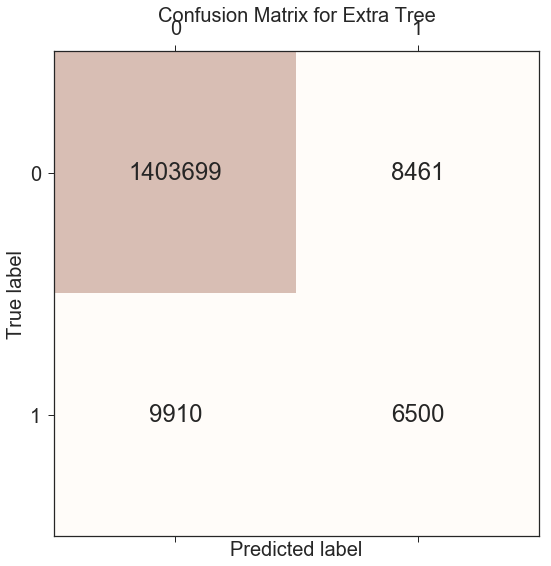

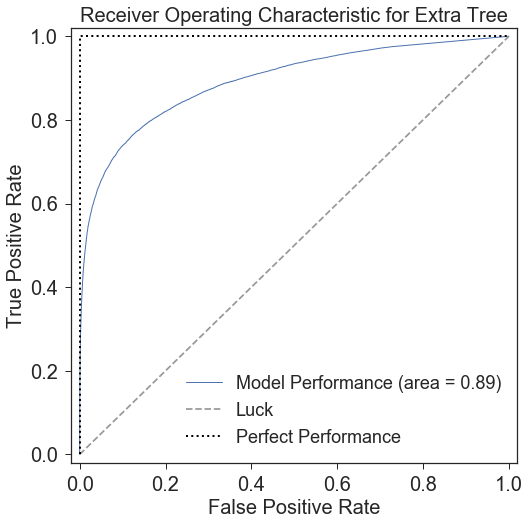

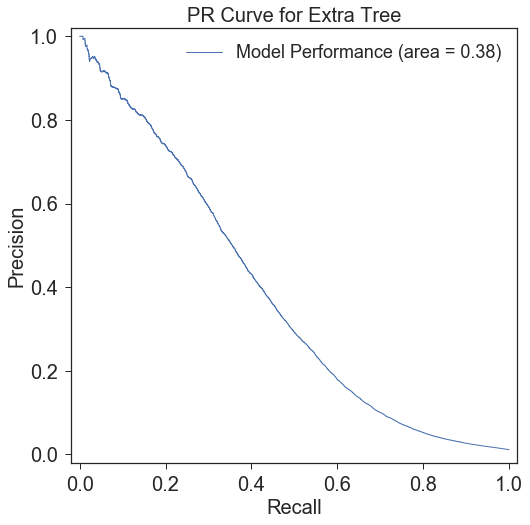

In [83]:
%%time
ET_final = ExtraTreesClassifier(random_state=40, n_estimators = 50, min_samples_leaf=4, class_weight="balanced",
                               n_jobs=7)
ET_final.fit(X_train, y_train)
result(ET_final, X_train, y_train, X_test, y_test, train_result=False, clf_name="Extra Tree")

We can pickle the final model now.

In [84]:
import dill
dill.dump(ET_final, open('ExtraTree.pkl', 'wb'))

## Function to calculate various evaluation metrics and plot ROC and PR curves

In [355]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.4f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.4f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)

In [1]:
#Flight (12)
Carrier
Distance
Month_Dest
Month_Origin
DayOfWeek_Origin
DayOfWeek_Dest
Origin
Dest
DayOfMonth_Dest
DayofMonth_Origin
CRSDepHr
CRSArrHr

#Weather (16)
Humidity_Origin
Humidity_Dest
Temperature_Origin
Temperature_Dest
Visibility_Origin
Visibility_Dest
DewPoint_Dest
DewPoint_Origin
Condition_Origin
Condition_Dest
WindDirection_Origin
WindDirection_Dest
Pressure_Origin
WindSpeed_Origin
WindSpeed_Dest
Pressure_Dest

#History (24)
Ncan_30
Ncan_10
Ncan_20
ArrDelayMax_10
DepDelayMax_10
ArrDelayMax_30
TaxiOutMedian_30
TaxiOutMedian_20
ArrDelayMax_20
DepDelayMax_20
Nflights_30
Nflights_20
ArrDelayMedian_10
ArrDelayMedian_30
ArrDelayMedian_20
TaxiInMedian_30
TaxiOutMedian_10
DepDelayMax_30
TaxiInMedian_20
Nflights_10
TaxiInMedian_10
DepDelayMedian_30
DepDelayMedian_20
DepDelayMedian_10

SyntaxError: invalid syntax (<ipython-input-1-7cbd3891c94f>, line 31)

In [2]:
factors = ["Flight", "Weather", "History"]

In [3]:
var_counts = [12, 16, 24]

In [36]:
def hide_topright(ax):
    """ This function removes the top and right border lines from a figure.
    
    Parameters
    ----------
    ax : An instance of Axes
    """
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

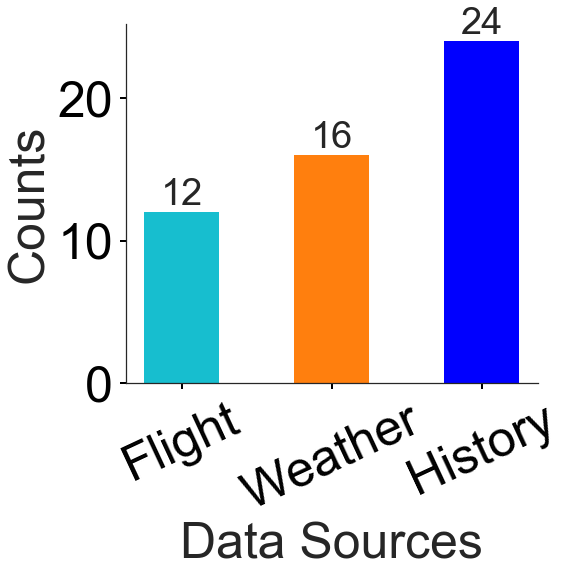

In [70]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom', size= 38)

clrs = [tableau20[18], tableau20[2], "blue"]
fs = 50 # font size
fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(np.arange(3), var_counts, width=0.5, color=clrs, capsize=100)
ax.set_xlabel('Data Sources', size = fs)
ax.set_ylabel('Counts', size = fs)
ax.xaxis.set_major_locator(MaxNLocator(3))
ax.set_xticklabels(('dummy', 'Flight', 'Weather', 'History'))
ax.tick_params(direction='out', length=6, width=2, colors='k', labelsize=fs)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=25)
autolabel(rects1)
hide_topright(ax)

plt.tight_layout()
savefig('Var_Counts.pdf')